**Warning:** This notebook may be a symptom of [DKE-19](https://medium.com/@noahhaber/flatten-the-curve-of-armchair-epidemiology-9aa8cf92d652).

# SIR models

Here we'll try to run a simple epidemiological model that may help us understand way fitting an exponential function is not helpful, and why epidemiologists still call some systems of spread exponential. *I will not even try fitting it to data*, because that is a whole different ball-game. 

This notebook is heavily based on [Lyle Ungar](https://www.cis.upenn.edu/~ungar/)'s public [journal club](https://www.crowdcast.io/e/journal-club-with-lyle) (organized by Konrad Kording) where he discusses [this paper](https://science.sciencemag.org/content/early/2020/03/24/science.abb3221) (the model equations are in the supplementary material) and on this [R notebook](https://staff.math.su.se/hoehle/blog/2020/03/16/flatteningthecurve.html) by [Michael Höhle](https://staff.math.su.se/hoehle/). I recommend both if you just want to understand what's going on. However, if you want to play with these models, and you know a little Python, this may be for you. 

The first thing is to explain the letters in SIR. They stand for:
1. Susceptible
2. Infected
3. Removed

These are three stages that every member of a population can be in during the outbreak of a virus. At the start of the outbreak of a new virus, everyone (supposedly) is in the first group: Susceptible. Susceptible people have never had the virus or a vaccine and hence have no immunity. As long as there is no vaccine, the only way to get out of this group is to become Infected. Infected people now have the virus, and they can transmit it to others as well. You can not go back to becoming Susceptible, the only way out of the Infected group of people is to go to the Removed group of people. You can be Removed in several ways. The most gruesome way is to die, but you can also spontaneously recover and become immune, and perhaps another way to no longer be counted as Infected is to be quarantined so that you no longer transmit the virus to others.

In this simple model (I'll talk about why it is simple at the end) we'll use the three capitalized letters to denote the three stage people can be in.

Now we need to some other variables that regulate how many people move from one stage to the next. First: β, a rate parameter controlling how many susceptible people get infected by the already infected people, given that they have contact with infected people. Second: c, the probability of contact with a person. Third: D, the duration that people stay in Infected, or alternatively: the rate of recovery. And finally N: the total number of people in the population.

## Made up numbers

I've made up some numbers and used others that I have seen on social media, but these in no way reflect any actual data:

β = 0.6

c = 0.6

D = 6.25 (It should be more like 2 weeks, but during the first part, people are not infectuous, so this is a short-cut)

N = 37625097 (inhabitants of Canada according to Wikipedia)

We then get a few equations that control what happens to each of the 3 parts of the population in discrete time steps (let's say days). To begin with, the group of people in S decreases as they get infected, and this by how much:

\begin{equation}
\frac{dS}{dt} = - \beta c\frac{I}{N}
\end{equation}

The group of Infected people increases by just as much as the group of Susceptible people decreases, but also decreased by the amount of people that moves to the Removed group:

\begin{equation}
\frac{dI}{dt} = \beta c\frac{I}{N} - \frac{I}{D}
\end{equation}

The number of Removed people just grows with that last amount at every time step:

\begin{equation}
\frac{dR}{dt} = \frac{I}{D}
\end{equation}

We can now write a Python function that takes in all these parameters and simulates what happens for a given number of time steps:

In [0]:
import pandas as pd

def SIRmodel(N=37625097, beta=0.6, c=0.6, D=6.25, steps=500, policy={}):
  # we set up the populations (with 1 person infected)
  St = N - 1
  It = 1
  Rt = 0
  # these vectors will keep track of the populations over time steps:
  S, I, R = [], [], []
  for step in range(steps):
    # here we calculate by how much the populations change on every time step:
    newI = beta * c * (It / N) * St
    newR = It / D
    # and update the populations:
    St = St - newI
    It = It + newI - newR
    Rt = Rt + newR
    # and we store the values for all time steps:
    S.append(St)
    I.append(It)
    R.append(Rt)

    # the following few lines are to see what happens under policy changes:
    if (len(policy) > 0):
      if policy['threshold'] < It or policy['step'] == step:
        #print('implementing policy')
        print(step)
        for pk in policy.keys():
          if pk == 'c':
            c = policy[pk]
          if pk == 'beta':
            beta = policy[pk]
          if pk == 'D':
            D = policy[pk]
        policy = {}
  # after all time steps we return the populations over time as a data frame:
  SIR = pd.DataFrame({'S':S,'I':I,'R':R})
  return(SIR)


For convenience, we'll make a function that runs this model and also plots the number of people in each group over time:

In [0]:
import matplotlib.pyplot as plt

def plotSIRmodel(N=37625097, beta=0.6, c=0.6, D=6.25, steps=500, policy={}):
  
  # fix up the policy dictionary:
  if not('threshold' in policy.keys()):
    policy['threshold'] = N+1
  if not('step' in policy.keys()):
    policy['step'] = steps+1

  # run the actual model:
  SIR = SIRmodel(N=N, beta=beta, c=c, D=D, steps=steps, policy=policy)

  # create a figure with the model populations over time:
  fig = plt.figure()
  plt.plot(SIR['S'])
  plt.plot(SIR['I'])
  plt.plot(SIR['R'])
  plt.legend(['Susceptible','Infected','Removed'], edgecolor=[1,1,1])
  plt.show()


And let's see what it does with the default settings:

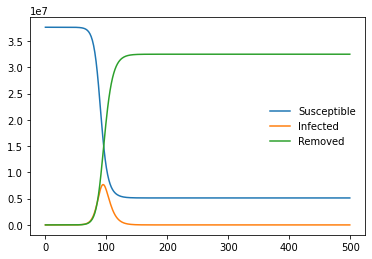

In [0]:
plotSIRmodel()

The orange line is the curve that is being shown on the news, and certainly having about 20% of the population infected does seem like it may overload any healthcare system. Not sure how realistic it all is. For example it is really taking of 60 - 70 days after the first infection or 2 months, and it might be more agressive.

Also notice that as a lot of people are appearing in the Removed pool (green line) there may be some kind of herd immunity developing. However, this is still not a really good strategy as a small percentage (1% - 4%?) but still a high number of the Removed people would not be immune but dead. If this sounds harsh, that's because it's not a very good strategy.

# What can we do?

Two solutions are constantly being mentioned in the news and social media: testing and self-isolating. Which one is better? There is a *policy* argument to the model function that allows changing parameters when the number of infected people exceeds some threshold. We will use this to simulate policy changes like self-isolation or a lot of testing.

## Self-isolation

So what would happen if we self isolate? This would really decrease the chance of getting into contact with an infected person; the c variable. Let's decrease c from 50% to 20% when we hit 2 million infections (not realistic, but if I make the number lower, you can't see what happens):

80


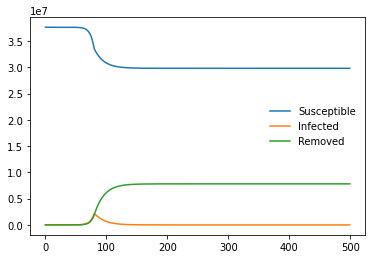

In [0]:
plotSIRmodel(policy={'threshold':2000000.0, 'c':.20})

So that would slow it down and decrease the peak number of people that are infected. It could be decreased more, and the only reason I didn't is because it would be harder or impossible to see on this plot that only has 300 time steps.

## Testing, testing, testing

What would testing everyone do? I'd say that if we test a lot, this will move Infected people into quarantine which will effectively put them in the Removed group, so that we can simulate this by decreasing D from 7 to 2.4:

In [0]:
plotSIRmodel(policy={'threshold':2000000, 'D':2.4})

So this simple model may explain how both of the solutions that people are promoting can help. Of course, since the numbers here are completely made up, this is not a prediction of what would really happen if one would try to implement one of the solutions. 

# Simple model

But it is also still a simple model. More sophisticated models simply have more moving parts, but are based on the same principles. There are also SEIR models, that add an Exposed stage, where people have caught the virus but are not yet infectuous. (If this idea was added to SIR models later on, that could explain why the terminology doesn't make a lot of sense.) They can also split the Infected group into documented and undocumented Infected people. Since these would have more severe and barely noticable symptoms (like coughing) they are also more or less infectuous, which is reflected in model parameters. You can than also add several cities or regions with mobility between regions, to see how a virus may spread from one region to the next. Finally, different age groups also behave differently (may self-isolate better or worse, are more or less mobile, meet more or less people by default, be more or less symptomatic and so forth). So with all those nuances added, especially all the different regions, then (according to the paper linked at the top) there is actually enough data, particularly from Chine, to fit the model.

# Exponential curves

Why do people plot exponential curves? These kinds of models do allow some kind of overall infection rate to be calculated: R0. But this is the infection rate at time zero. It changes dramatically when more people move from the Susceptible pool, so that just fitting an exponential curve is not a good way to predict anything at all. Still the number R0 does say something about how infectious a virus is, or how quickly and how far it will spread through the population.

# R0

So how do we get this R0? You can calculate it from the model parameters after it has been fit to the data. For the model above it comes from multiplying β, c and D:

\begin{equation}
R_0 = \beta c D
\end{equation}

This makes sense as this is the probability of infecting people (β * c) per time unit (the probability of a contact multiplied by the infection rate), multiplied by the number of time units that people are infectuous (D). So you get the number of people that every infected person will infect (on average). Let's do it for the model above:


In [0]:
beta = 0.6
c = .6
D = 6.25
R0 = ( beta * c * D )
print(R0)
# c: .6 or .2
# D: 6.25 or 2.4

2.25


Purely coincidentally this is pretty close to what you may have seen on social media. ;) Of course, you can change the numbers above to see what happens when c is lowered to .01 or when D is lowered to 1. And whith such R0's or at earlier points in the outbreak, this will limit the epidemic even more.

# Other sources

Matt pointed out this cool R package:
[tidycovid19](https://joachim-gassen.github.io/tidycovid19/)

Which doesn't contain any data, but rather has functions to access all sorts of publicly available data on Covid-19.